# Introduction

The high given AOV makes me think there are outliers in the dataset. In this notebook, I check for them, filter them out, and return an adjusted AOV (can also just return the median to take care of outliers). Then I calculate a new metric - the mode - for the dataset. The mode answers the most common purchase price per order, which is a better indicator of the most likely amount someone will spend than the mean.


We'll find that if we want to make decisions such as "Free shipping if you spend at least \\$300", it is better to do so with the mode than with the mean. Most customers likely won't spend at least the mean if they see a threshold like \\$300, but if the decision is based on a mode of \\$150 or \\$200, it's more palatable and will push customer who might not spend much on shoes to spend a bit more.

Then I group each customer into deciles by their total order_amount which we can use to target specific customers with campaigns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv')
data['created_at'] = pd.to_datetime(data['created_at'])
data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 04:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 04:35:11


In [3]:
len(data), data.order_id.nunique()

(5000, 5000)

In [4]:
data.dtypes

order_id                   int64
shop_id                    int64
user_id                    int64
order_amount               int64
total_items                int64
payment_method            object
created_at        datetime64[ns]
dtype: object

In [5]:
data.isna().sum()

order_id          0
shop_id           0
user_id           0
order_amount      0
total_items       0
payment_method    0
created_at        0
dtype: int64

Verify that AOV is as given ($3145.13) and that the data is over 30 days. Average Order Value = revenue / # of orders

In [6]:
min(data.created_at), max(data.created_at)

(Timestamp('2017-03-01 00:08:09'), Timestamp('2017-03-30 23:55:35'))

In [7]:
data['order_amount'].sum() / len(data) # naive aov

3145.128

## Check for outliers

Quick check for existence of outliers. Note: minimum order amount looks reasonable ($90.00 for shoes sounds fine).

Maximum order amount, $704 000.00, however, looks odd. 
total_items = 2000 might also be a lot for an individual buyer, but could be a reasonable bulk order from another business. Lets investigate.

In [8]:
data.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


Ah, so looks like we have a few anomalous entries for user_id=607 and shop_id=42. If it were orders with different user_ids, who have a history of large orders or are well known large businesses, this might not be as suspicious. Also, the frequency and timestamps for these orders is far too frequent for the order value. It's safe to drop these rows and recalculate the average order value, but lets do some more exploration.

In [9]:
704000/2000 # though on the high side, it's reaching the realm of plausible average shoe value.

352.0

In [10]:
data[data['order_amount']==704000].sort_values('created_at')

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
520,521,42,607,704000,2000,credit_card,2017-03-02 04:00:00
4646,4647,42,607,704000,2000,credit_card,2017-03-02 04:00:00
60,61,42,607,704000,2000,credit_card,2017-03-04 04:00:00
15,16,42,607,704000,2000,credit_card,2017-03-07 04:00:00
2297,2298,42,607,704000,2000,credit_card,2017-03-07 04:00:00
1436,1437,42,607,704000,2000,credit_card,2017-03-11 04:00:00
2153,2154,42,607,704000,2000,credit_card,2017-03-12 04:00:00
1362,1363,42,607,704000,2000,credit_card,2017-03-15 04:00:00
1602,1603,42,607,704000,2000,credit_card,2017-03-17 04:00:00
1562,1563,42,607,704000,2000,credit_card,2017-03-19 04:00:00


In [11]:
cols = ['order_amount', 'total_items']
Q1 = data[cols].quantile(0.25)
Q3 = data[cols].quantile(0.75)
IQR = Q3 - Q1

data_no_outliers_iqr = data.loc[~((data[cols] < (Q1 - 1.5 * IQR)) | 
                             (data[cols] > (Q3 + 1.5 * IQR))).any(axis=1)].copy()
data_no_outliers_iqr.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000
mean,2497.395966,49.852645,849.905742,293.715374,1.950196
std,1443.356555,29.049171,86.887496,144.453395,0.919791
min,1.000000,1.000000,700.000000,90.000000,1.000000
25%,1244.500000,24.000000,776.000000,162.000000,1.000000
50%,2498.000000,50.000000,850.000000,280.000000,2.000000
75%,3749.500000,74.000000,925.000000,380.000000,3.000000
max,5000.000000,100.000000,999.000000,730.000000,5.000000


There are a few valid items in terms of order_amount and total_items that are considered outliers by the IQR outlier detection method. Only the one with order_id=692 is a true extreme value due to its order_amount. The others could be plausible orders and we could keep them, but since there are so few, lets drop them along with all the other outliers. They pull up the mean value of orders, but the metric that is more important to business owners is the most frequent value of an order - the mode.

In [12]:
data[(data['total_items'] < 30) & (data['total_items'] > 5)]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
691,692,78,878,154350,6,debit,2017-03-27 22:51:43
1563,1564,91,934,960,6,debit,2017-03-23 08:25:49
2127,2128,83,745,774,6,cash,2017-03-27 06:59:46
2307,2308,61,723,948,6,credit_card,2017-03-26 11:29:37
3252,3253,67,706,786,6,credit_card,2017-03-29 16:05:41
3538,3539,43,830,1086,6,debit,2017-03-17 19:56:29
3865,3866,68,815,816,6,debit,2017-03-11 09:31:50
4141,4142,54,733,1064,8,debit,2017-03-07 17:05:18
4711,4712,86,883,780,6,cash,2017-03-18 14:18:19
4847,4848,13,993,960,6,cash,2017-03-27 11:00:45


## New Metric

The new Average Order Value is \\$293.72 (mean of order_amount in `data_no_outliers_iqr`), which is more reasonable. While this is an informative metric, it doesn't complete the picture. Another metric that is useful is the mode, which gives a sense of the most common spending profile.

With no rounding of order_amount, the mode is  \\$153.00.

Rounding to the nearest 10, the mode is \\$160.00. And rounding to the nearest 5, the mode is \\$130.00.

So one might set incentives like "Free shipping over $175" or similar.

The median is also calculated as \\$280.00, which is close to the mean, so we've cleaned the data from outliers decently well. In fact, the median of order_amount in the original data is \\$284.00, so if we didn't want to clean the data we could just answer median is a better metric than the AOV.



In [13]:
print('Clean Data Median', data_no_outliers_iqr['order_amount'].median())
print('Original median', data['order_amount'].median())
print('Clean Data Mode', data_no_outliers_iqr['order_amount'].mode().values)

Clean Data Median 280.0
Original median 284.0
Clean Data Mode [153]


In [14]:
def round_nearest(value, nearest):
    return int(nearest * round(float(value) / nearest))

In [15]:
def print_metrics(nearest=10):
    data_no_outliers_iqr['rounded_order_amount'] = data_no_outliers_iqr['order_amount'].apply(lambda x: round_nearest(x, nearest))
    plt.hist(data_no_outliers_iqr['rounded_order_amount']);
    plt.title('Frequency of order amounts')
    plt.xlabel('Order amount ($)')
    plt.ylabel('Number of orders')
    print('Mode', data_no_outliers_iqr['rounded_order_amount'].mode().values[0])

The lowest prices are more common than the highest prices, as expected.

Mode 130


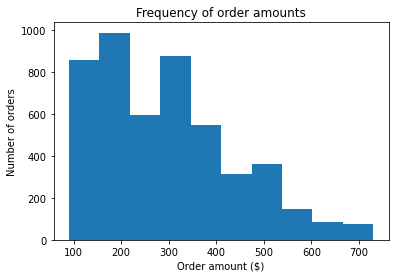

In [16]:
print_metrics(nearest=5)

Mode 160


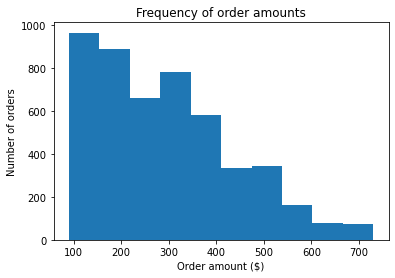

In [17]:
print_metrics(nearest=10)

Mode of order_amount for stores with ID 1 through 100:

In [18]:
data_no_outliers_iqr.groupby(['shop_id'])['order_amount'].apply(pd.Series.mode).values

array([316,  94, 296, 256, 284, 374, 112, 132, 236, 148, 444, 184, 201,
       320, 116, 306, 156, 176, 156, 163, 127, 284, 292, 312, 280, 130,
       176, 338, 328, 326, 153, 258, 202, 173, 122, 328, 260, 142, 380,
       268, 161, 322, 118, 352, 181, 144, 142, 166, 145, 234, 258, 386,
       187, 292, 224, 266, 171, 342, 117, 294, 138, 178, 177, 316, 160,
       272, 266, 399, 308, 161, 131, 136, 262, 346, 328, 160, 330, 153,
       256, 310, 312, 181, 290, 354, 177, 129, 306, 344, 260, 149, 176,
       196, 356, 160, 180, 114, 402, 336, 153, 162, 133, 195, 111])

## Return on Investment  / Next Steps
How can we group customers and either prod high paying customers to keep coming back or nurture low paying customers to spend more?

Can also do the grouping for well performing/under performing stores.

In [19]:
grouped_users = data_no_outliers_iqr.groupby('user_id', as_index=False)['order_amount'].sum()

# + 1 just to make it jive with talking about the 1st, 2nd, ..., 10th deciles rather than 0th
grouped_users['decile'] = pd.qcut(grouped_users.order_amount, q=10, labels=False) + 1 
grouped_users.head()

,user_id,order_amount,decile
0,700,4790,6
1,701,5162,7
2,702,4521,5
3,703,6091,9
4,704,3854,3


In [20]:
grouped_users.describe()

,user_id,order_amount,decile
count,300.000000,300.000000,300.00000
mean,849.500000,4757.210000,5.50000
std,86.746758,1299.227102,2.87708
min,700.000000,2102.000000,1.00000
25%,774.750000,3778.750000,3.00000
50%,849.500000,4629.500000,5.50000
75%,924.250000,5541.500000,8.00000
max,999.000000,8952.000000,10.00000


##### Example of usage: may target these customers of interest

In [21]:
def get_user_ids_for_decile(df, decile: int):
    return df[df['decile'] == decile].user_id.values

In [22]:
get_user_ids_for_decile(grouped_users, 10) 

array([705, 718, 734, 736, 739, 745, 756, 759, 768, 778, 785, 786, 787,
       789, 791, 793, 799, 811, 842, 847, 857, 868, 875, 923, 932, 934,
       969, 975, 980, 999])

#### Visualize the deciles

In [23]:
aggregated_deciles = grouped_users.groupby('decile', as_index=False)['order_amount'].median()
aggregated_deciles

,decile,order_amount
0,1,2867.0
1,2,3470.5
2,3,3775.5
3,4,4135.0
4,5,4496.5
5,6,4737.5
6,7,5086.5
7,8,5545.0
8,9,6222.0
9,10,7086.5


values [2867.  3470.5 3775.5 4135.  4496.5 4737.5 5086.5 5545.  6222.  7086.5]


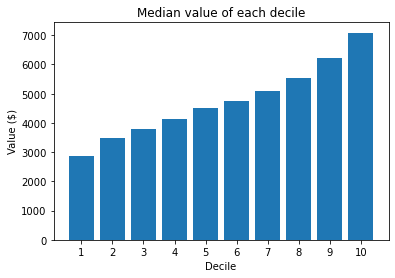

In [24]:
values = aggregated_deciles['order_amount'].values
deciles = aggregated_deciles['decile'].values
print('values', values)
plt.bar(deciles, values);
plt.xticks(deciles)
plt.title('Median value of each decile')
plt.ylabel('Value ($)')
plt.xlabel('Decile');